In [1]:
import torch
from utils import load_ckpt, visualize_depth
from collections import defaultdict
import matplotlib.pyplot as plt
import time

from models.rendering import *
from models.nerf import *

import metrics

from datasets import dataset_dict

torch.backends.cudnn.benchmark = True
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ', '.join([str(gpu) for gpu in [1]])
print(os.environ['CUDA_VISIBLE_DEVICES'])

1


In [2]:
# Change to your settings...
############################
N_vocab = 1500
encode_appearance = True
N_a = 48
encode_transient = True
N_tau = 16
beta_min = 0.03 # doesn't have effect in testing
ckpt_path = 'ckpts/zjui_library_scale8_nerfw/epoch=10.ckpt'

N_emb_xyz = 10
N_emb_dir = 4
N_samples = 128
N_importance = 128
use_disp = False
chunk = 1024*32
#############################

embedding_xyz = PosEmbedding(N_emb_xyz-1, N_emb_xyz)
embedding_dir = PosEmbedding(N_emb_dir-1, N_emb_dir)
embeddings = {'xyz': embedding_xyz, 'dir': embedding_dir}
if encode_appearance:
    embedding_a = torch.nn.Embedding(N_vocab, N_a).cuda()
    load_ckpt(embedding_a, ckpt_path, model_name='embedding_a')
    embeddings['a'] = embedding_a
if encode_transient:
    embedding_t = torch.nn.Embedding(N_vocab, N_tau).cuda()
    load_ckpt(embedding_t, ckpt_path, model_name='embedding_t')
    embeddings['t'] = embedding_t
    

nerf_coarse = NeRF('coarse',
                   in_channels_xyz=6*N_emb_xyz+3,
                   in_channels_dir=6*N_emb_dir+3).cuda()
nerf_fine = NeRF('fine',
                 in_channels_xyz=6*N_emb_xyz+3,
                 in_channels_dir=6*N_emb_dir+3,
                 encode_appearance=encode_appearance,
                 in_channels_a=N_a,
                 encode_transient=encode_transient,
                 in_channels_t=N_tau,
                 beta_min=beta_min).cuda()

load_ckpt(nerf_coarse, ckpt_path, model_name='nerf_coarse')
load_ckpt(nerf_fine, ckpt_path, model_name='nerf_fine')

models = {'coarse': nerf_coarse, 'fine': nerf_fine}

In [3]:
@torch.no_grad()
def f(rays, ts, **kwargs):
    """Do batched inference on rays using chunk."""
    B = rays.shape[0]
    results = defaultdict(list)
    for i in range(0, B, chunk):
        kwargs_ = {}
        if 'a_embedded' in kwargs:
            kwargs_['a_embedded'] = kwargs['a_embedded'][i:i+chunk]
        rendered_ray_chunks = \
            render_rays(models,
                        embeddings,
                        rays[i:i+chunk],
                        ts[i:i+chunk],
                        N_samples,
                        use_disp,
                        0,
                        0,
                        N_importance,
                        chunk,
                        dataset.white_back,
                        test_time=True,
                        **kwargs_)

        for k, v in rendered_ray_chunks.items():
            results[k] += [v]

    for k, v in results.items():
        results[k] = torch.cat(v, 0)
    return results

# Test on the image of Fig 4 in the paper

In [4]:
dataset = dataset_dict['phototourism'] \
          ('/data/ybyang/nerf_data/phototourism_data/zjui_library_FULL',
           split='test_train',
           img_downscale=4, use_cache=True)

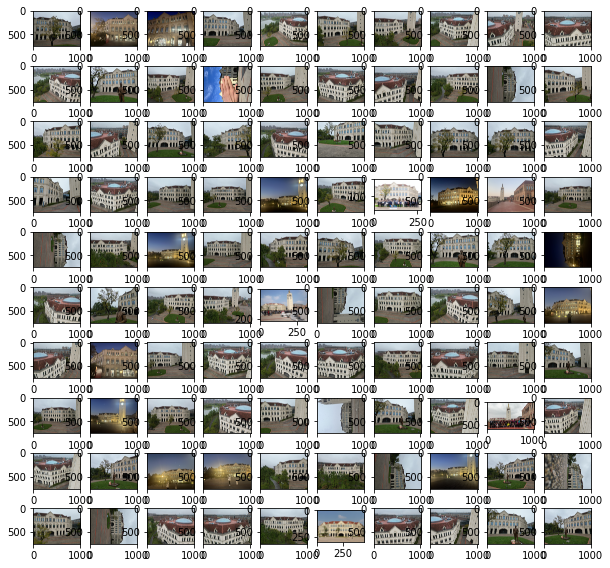

In [5]:
plt.subplots(figsize=(10, 10))
for i in range(100):
    img_wh = tuple(dataset[i]['img_wh'].numpy())
    plt.subplot(10, 10, i+1)
    plt.imshow(dataset[i]['rgbs'].view(img_wh[1], img_wh[0], 3).cpu().numpy())

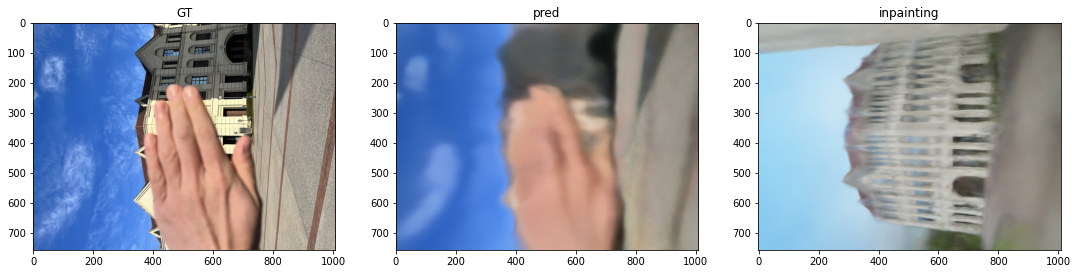

In [10]:
sample = dataset[13]
rays = sample['rays'].cuda()
ts = sample['ts'].cuda()
results = f(rays, ts)

img_wh = tuple(sample['img_wh'].numpy())
img_gt = sample['rgbs'].view(img_wh[1], img_wh[0], 3)
img_pred = results['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
depth_pred = results['depth_fine'].view(img_wh[1], img_wh[0])
img_pred_static = results['rgb_fine_static'].view(img_wh[1], img_wh[0], 3).cpu().numpy()

plt.subplots(figsize=(15, 8))
plt.tight_layout()
plt.subplot(231)
plt.title('GT')
plt.imshow(img_gt)
plt.subplot(232)
plt.title('pred')
plt.imshow(img_pred)
plt.subplot(233)
plt.title('inpainting')
plt.imshow(img_pred_static)
plt.show()

# Test on another highly occluded data

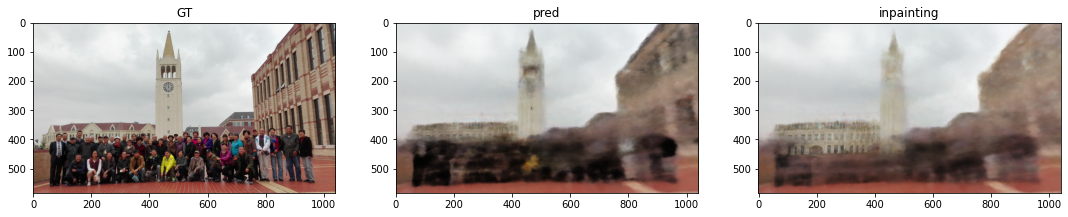

In [15]:
sample = dataset[78]
#  [36,80]
rays = sample['rays'].cuda()
ts = sample['ts'].cuda()

results = f(rays, ts)

img_wh = tuple(sample['img_wh'].numpy())
img_gt = sample['rgbs'].view(img_wh[1], img_wh[0], 3)
img_pred = results['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
depth_pred = results['depth_fine'].view(img_wh[1], img_wh[0])
img_pred_static = results['rgb_fine_static'].view(img_wh[1], img_wh[0], 3).cpu().numpy()

plt.subplots(figsize=(15, 8))
plt.tight_layout()
plt.subplot(231)
plt.title('GT')
plt.imshow(img_gt)
plt.subplot(232)
plt.title('pred')
plt.imshow(img_pred)
plt.subplot(233)
plt.title('inpainting')
plt.imshow(img_pred_static)
plt.show()


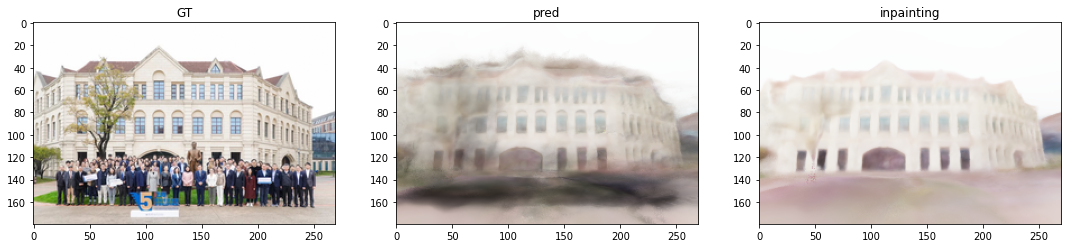

In [ ]:
sample = dataset[108]
#  [36,80]
rays = sample['rays'].cuda()
ts = sample['ts'].cuda()

results = f(rays, ts)

img_wh = tuple(sample['img_wh'].numpy())
img_gt = sample['rgbs'].view(img_wh[1], img_wh[0], 3)
img_pred = results['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
depth_pred = results['depth_fine'].view(img_wh[1], img_wh[0])
img_pred_static = results['rgb_fine_static'].view(img_wh[1], img_wh[0], 3).cpu().numpy()

plt.subplots(figsize=(15, 8))
plt.tight_layout()
plt.subplot(231)
plt.title('GT')
plt.imshow(img_gt)
plt.subplot(232)
plt.title('pred')
plt.imshow(img_pred)
plt.subplot(233)
plt.title('inpainting')
plt.imshow(img_pred_static)
plt.show()

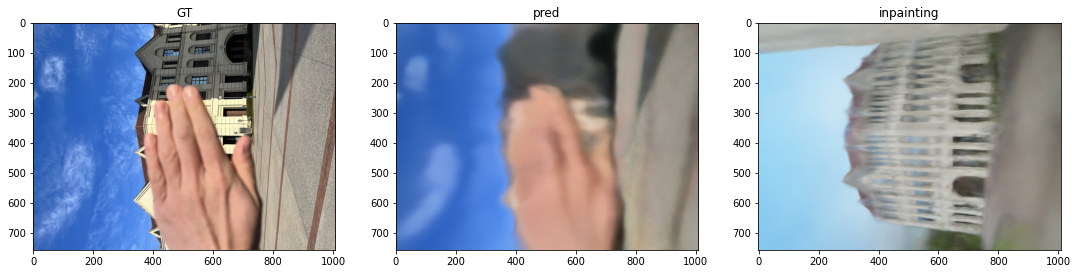

In [11]:
sample = dataset[13]
#  [36,80]
rays = sample['rays'].cuda()
ts = sample['ts'].cuda()

results = f(rays, ts)

img_wh = tuple(sample['img_wh'].numpy())
img_gt = sample['rgbs'].view(img_wh[1], img_wh[0], 3)
img_pred = results['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
depth_pred = results['depth_fine'].view(img_wh[1], img_wh[0])
img_pred_static = results['rgb_fine_static'].view(img_wh[1], img_wh[0], 3).cpu().numpy()

plt.subplots(figsize=(15, 8))
plt.tight_layout()
plt.subplot(231)
plt.title('GT')
plt.imshow(img_gt)
plt.subplot(232)
plt.title('pred')
plt.imshow(img_pred)
plt.subplot(233)
plt.title('inpainting')
plt.imshow(img_pred_static)
plt.show()

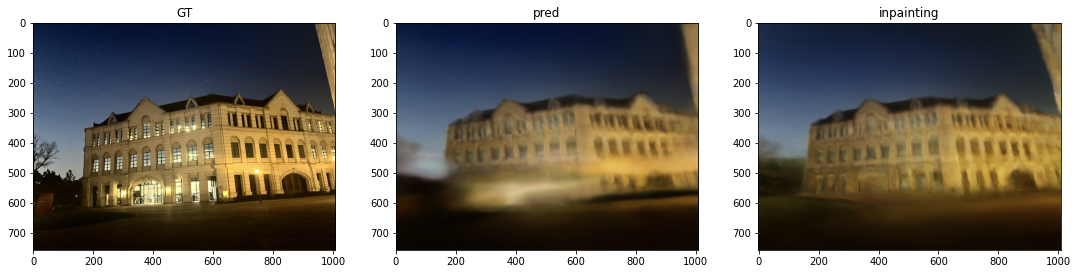

In [13]:
sample = dataset[37]
#  [36,80]
rays = sample['rays'].cuda()
ts = sample['ts'].cuda()

results = f(rays, ts)

img_wh = tuple(sample['img_wh'].numpy())
img_gt = sample['rgbs'].view(img_wh[1], img_wh[0], 3)
img_pred = results['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
depth_pred = results['depth_fine'].view(img_wh[1], img_wh[0])
img_pred_static = results['rgb_fine_static'].view(img_wh[1], img_wh[0], 3).cpu().numpy()

plt.subplots(figsize=(15, 8))
plt.tight_layout()
plt.subplot(231)
plt.title('GT')
plt.imshow(img_gt)
plt.subplot(232)
plt.title('pred')
plt.imshow(img_pred)
plt.subplot(233)
plt.title('inpainting')
plt.imshow(img_pred_static)
plt.show()

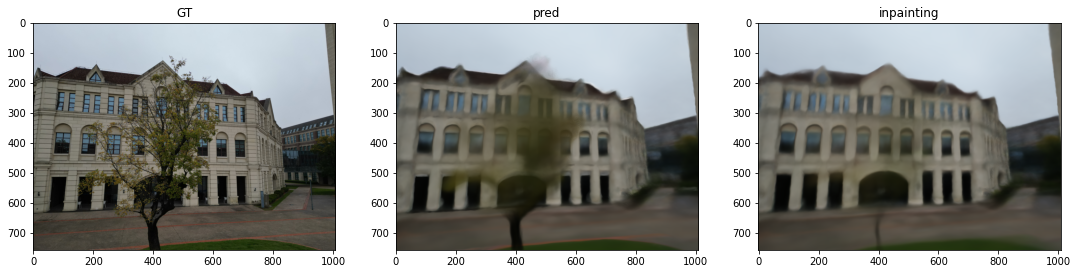

: 

In [16]:
sample = dataset[0]
rays = sample['rays'].cuda()
ts = sample['ts'].cuda()
results = f(rays, ts)

img_wh = tuple(sample['img_wh'].numpy())
img_gt = sample['rgbs'].view(img_wh[1], img_wh[0], 3)
img_pred = results['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
depth_pred = results['depth_fine'].view(img_wh[1], img_wh[0])
img_pred_static = results['rgb_fine_static'].view(img_wh[1], img_wh[0], 3).cpu().numpy()

plt.subplots(figsize=(15, 8))
plt.tight_layout()
plt.subplot(231)
plt.title('GT')
plt.imshow(img_gt)
plt.subplot(232)
plt.title('pred')
plt.imshow(img_pred)
plt.subplot(233)
plt.title('inpainting')
plt.imshow(img_pred_static)
plt.show()

# Interpolate embedding for appearance change (Fig 8 in the paper)
### left image: train number 53; right image: train number 111
### The pose is fixed to that of the right image, and the appearance embedding is interpolated

In [66]:
left_sample = dataset[37]
right_sample = dataset[70]

right_rays = right_sample['rays'].cuda()
right_ts = right_sample['ts'].cuda()
left_rays = left_sample['rays'].cuda()
left_ts = left_sample['ts'].cuda()
left_a_embedded = embedding_a(left_sample['ts'].cuda())
right_a_embedded = embedding_a(right_sample['ts'].cuda())

results_list = [left_sample]

kwargs = {'a_embedded': left_a_embedded}
results_list += [f(left_rays, left_ts, **kwargs)]
for i in range(6):
    kwargs = {'a_embedded': right_a_embedded*i/5+left_a_embedded[0]*(1-i/5)}
    results_list += [f(right_rays, right_ts, **kwargs)]

results_list += [right_sample]

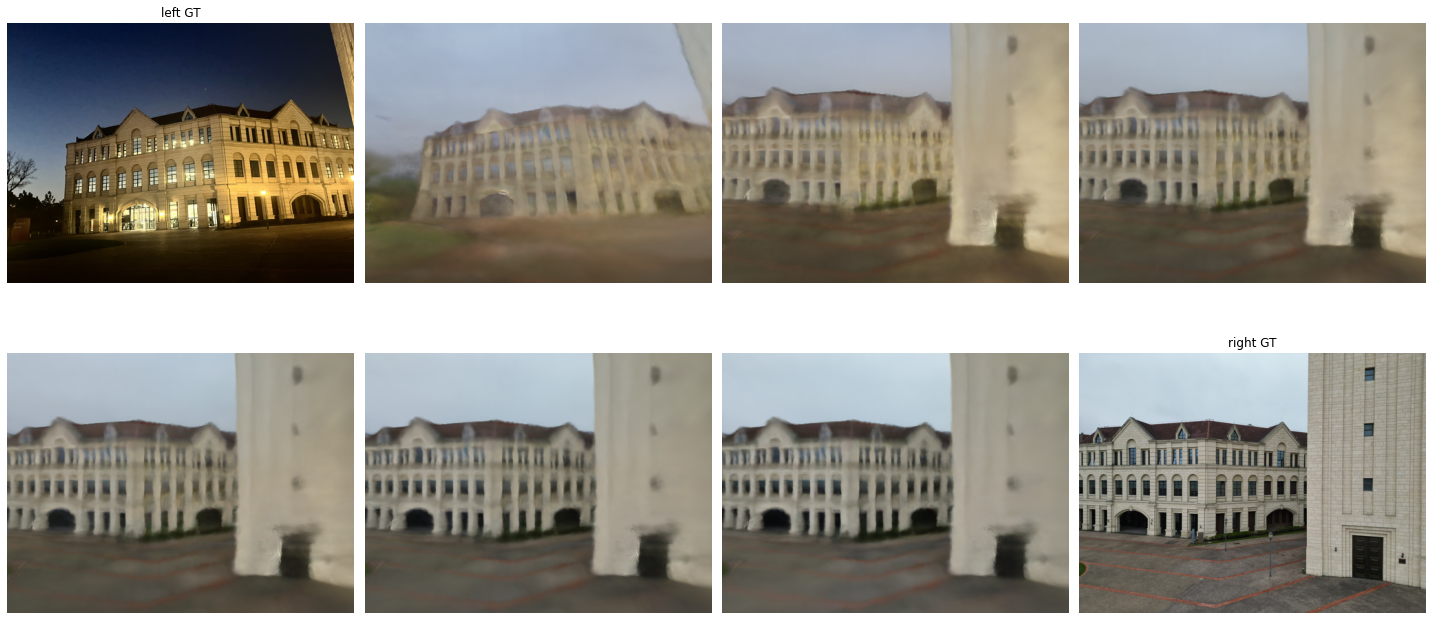

: 

In [67]:
plt.subplots(figsize=(20, 10))
for i, results in enumerate(results_list):
    if i == 0:
        img_wh = tuple(results['img_wh'].numpy())
        left_GT = results['rgbs'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
        plt.subplot(2,4,1)
        plt.axis('off')
        plt.title('left GT')
        plt.imshow(left_GT)
    elif i == 8:
        img_wh = tuple(results['img_wh'].numpy())
        right_GT = results['rgbs'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
        plt.subplot(2,4,8)
        plt.axis('off')
        plt.title('right GT')
        plt.imshow(right_GT)
    elif i == 1:
        img_wh = tuple(left_sample['img_wh'].numpy())
        img_pred = results['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
        plt.subplot(2, 4, 2)
        plt.axis('off')
        plt.imshow(img_pred)
    else:
        img_wh = tuple(right_sample['img_wh'].numpy())
        img_pred = results['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
        plt.subplot(2, 4, i+1)
        plt.axis('off')
        plt.imshow(img_pred)
plt.tight_layout()
plt.show()

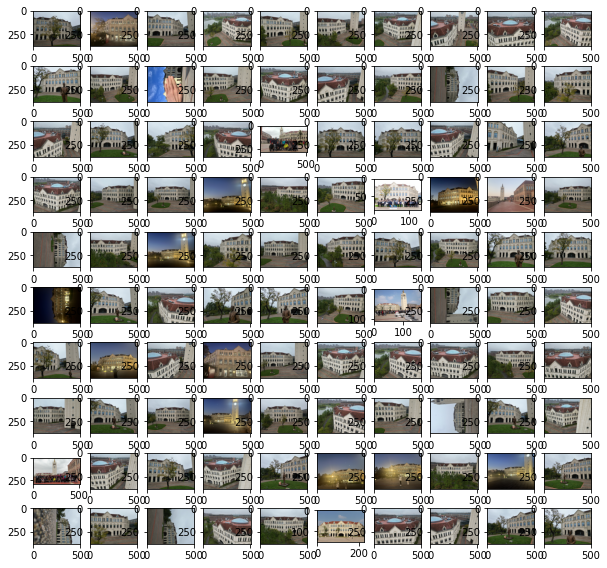